In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

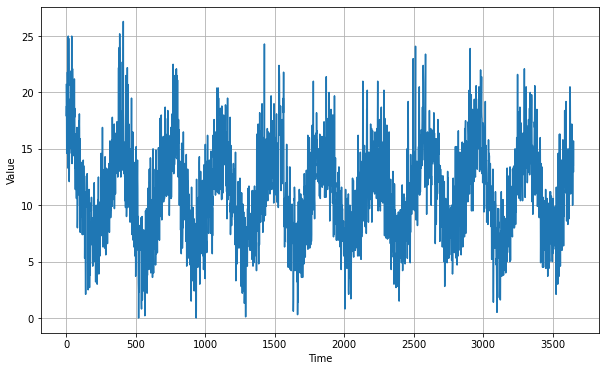

In [3]:
import csv
time_step = []
temps = []

with open('tmp2/daily-min-temperatures.csv') as csvfile:
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
  reader = csv.reader(csvfile, delimiter = ',')
  next(reader)
  for i, row in enumerate(reader):
    temps.append(float(row[1]))
    time_step.append(i + 1)
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [4]:
split_time = 2500
time_train = np.array(time_step[:split_time])
x_train = np.array(temps[:split_time])
time_valid = np.array(time_step[split_time:])
x_valid = np.array(temps[split_time:])

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # YOUR CODE HERE
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [6]:
def model_forecast(model, series, window_size):
    # YOUR CODE HERE
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  # YOUR CODE HERE
  tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 1s 54ms/step - loss: 10.4854 - mae: 10.9846
Epoch 2/100
10/10 [==============================] - 0s 50ms/step - loss: 10.4073 - mae: 10.9064
Epoch 3/100
10/10 [==============================] - 0s 46ms/step - loss: 10.3282 - mae: 10.8271
Epoch 4/100
10/10 [==============================] - 0s 40ms/step - loss: 10.2671 - mae: 10.7659
Epoch 5/100
10/10 [==============================] - 0s 40ms/step - loss: 10.2153 - mae: 10.7141
Epoch 6/100
10/10 [==============================] - 0s 48ms/step - loss: 10.1594 - mae: 10.6581
Epoch 7/100
10/10 [==============================] - 0s 43ms/step - loss: 10.0935 - mae: 10.5921
Epoch 8/100
10/10 [==============================] - 0s 42ms/step - loss: 10.0136 - mae: 10.5123
Epoch 9/100
10/10 [==============================] - 0s 48ms/step - loss: 9.9154 - mae: 10.4140
Epoch 10/100
10/10 [======

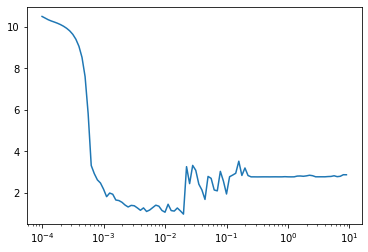

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.show()

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=window_size, batch_size=batch_size, 
                             shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  # YOUR CODE HERE
  tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(1)
])


optimizer = tf.keras.optimizers.SGD(lr=3e-3, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs = 100)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/100
10/10 [==============================] - 0s 37ms/step - loss: 10.2874 - mae: 10.7864
Epoch 2/100
10/10 [==============================] - 0s 47ms/step - loss: 9.5378 - mae: 10.0363
Epoch 3/100
10/10 [==============================] - 1s 54ms/step - loss: 6.3052 - mae: 6.7941
Epoch 4/100
10/10 [==============================] - 0s 47ms/step - loss: 3.3449 - mae: 3.8183
Epoch 5/100
10/10 [==============================] - 0s 46ms/step - loss: 2.8335 - mae: 3.3015
Epoch 6/100
10/10 [==============================] - 0s 48ms/step - loss: 2.4523 - mae: 2.9144
Epoch 7/100
10/10 [==============================] - 0s 44ms/step - loss: 1.9697 - mae: 2.4224
Epoch 8/100
10/10 [==============================] - 0s 45ms/step - loss: 2.2355 - mae: 2.6938
Epoch 9/100
10/10 [==============================] - 0s 49ms/step - loss: 1.7147 - mae: 2.1633
Epoch 10/100
10/10 [==============================] - 0s 48ms/step - loss: 1.5837 - mae: 2.0304
Epoch 11/100
10/10 [==========================

In [10]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

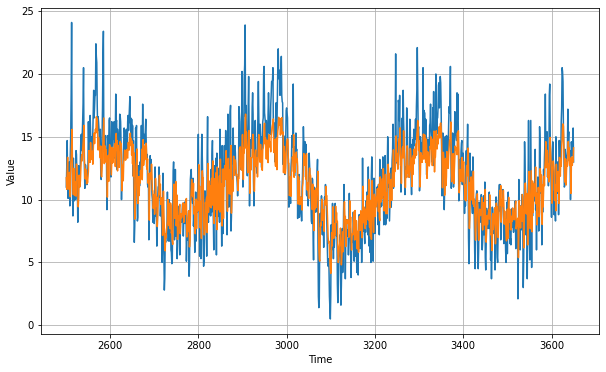

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [12]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.931984

In [13]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.7395735 10.822878  12.3538265 ... 13.0903845 13.020603  14.119822 ]
